# Coursework 2 -- Parabolic Equations

You are to use the two dimensional form of the Crank-Nicholson method to solver the isotropic heat conduction equation,

$$\frac{\partial T}{\partial t} = \kappa\left(\frac{\partial^2 T}{\partial x^2}+\frac{\partial^2 T}{\partial y^2}\right).$$

The <code>Grid</code> class, below, is taken from the BiCGStab workbook and will be used to generate the grid for this solver.  It has been extended to include an additional variable (time) in grid the object and to ensure that this is zero when the grid is created. <code>self.time</code> will be needed by the boundary condition routines.  The class also includes <code>self.kappa</code> which is used to store the thermal diffusivity.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

class Grid:
    '''Class defining a 2D computational grid.  The grid object
    contains is a regular cartesian grid with a single variable, u.
    It stores information about the number of grid points in the i
    and j directions, the ordinates of these points and the bottom
    left corner of the gird (the origin) and the top right corner
    (the extent).
    
    Written by Prof David Ingram, School of Engineering
    (c) 2022 The University of Edinburgh
    Licensed under CC-BY-NC.'''
    
    DIRICHLET_BC = 0
    NEUMANN_BC = 1

    BC_NAME = ['left', 'right', 'top', 'bottom']
    
    def __init__(self,ni,nj):
        # set up information about the grid
        self.origin = (0.0, 0.0)  # bottom left
        self.extent = (1.0, 1.0)  # top right
        self.Ni = ni # grid points in i direction
        self.Nj = nj # grid points in j direction
        
        # initialse x,y and u arrays
        self.u = np.zeros((nj, ni))
        self.x = np.zeros((nj, ni))
        self.y = np.zeros((nj, ni))
        
        # boundary conditions (left right top and bottom)
        self.BC = [self.DIRICHLET_BC, self.DIRICHLET_BC, 
                   self.DIRICHLET_BC, self.DIRICHLET_BC]
        
        # set the time
        self.time = 0.0
        self.kappa = 1.0

    def set_origin(self,x0,y0):
        self.origin = (x0, y0)
    
    def set_extent(self,width,height):
        self.extent = (width, height)
        
    def generate(self,Quiet=True):
        '''generate a uniformly spaced grid covering the domain from the
        origin to the extent.  We are going to do this using linspace from
        numpy to create lists of x and y ordinates and then the meshgrid
        function to turn these into 2D arrays of grid point ordinates.'''
        x_ord = np.linspace(self.origin[0], self.origin[0]+self.extent[0], self.Ni)
        y_ord = np.linspace(self.origin[1], self.origin[1]+self.extent[1], self.Nj)
        self.x, self.y = np.meshgrid(x_ord,y_ord)
        if not Quiet:
            print(self)

    def set_diffusivity(self,k):
        self.kappa = k
        
    def Delta_x(self):
        # calculate delta x
        return self.x[0,1]-self.x[0,0]
    
    def Delta_y(self):
        # calculate delta y
        return self.y[1,0]-self.y[0,0]
    
    def find(self,point):
        '''find the i and j ordinates of the grid cell which contains 
        the point (x,y).  To do this we calculate the distance from
        the point to the origin in the x and y directions and then
        divide this by delta x and delta y.  The resulting real ordinates
        are converted to indices using the int() function.'''
        grid_x = (point[0] - self.origin[0])/self.Delta_x()
        grid_y = (point[1] - self.origin[1])/self.Delta_y()
        return int(grid_x), int(grid_y)
    
    def set_Neumann_bc(self,side):
        try:
             self.BC[self.BC_NAME.index(side)] = self.NEUMANN_BC
        except:
             print('error {} must be one of {}'.format(side,self.BC_NAME))
     
    def set_Dirichlet_bc(self,side):
        try:
            self.BC[self.BC_NAME.index(side)] = self.DIRICHLET_BC
        except:
            print('error {} must be one of {}'.format(side,self.BC_NAME))
    
    def plot(self,title):
        '''produce a contour plot of the solutionat the current time'''
        
        # create a title
        caption = f'{title}, t={self.time}s ({self.Ni} x {self.Nj}) grid.'
        fig, ax1 = plt.subplots()
        
        # draw the plot
        cmap = plt.get_cmap('jet')
        cf = ax1.contourf(self.x,self.y,self.u,cmap=cmap, levels = 21)
        fig.colorbar(cf, ax=ax1)
        ax1.set_title(caption)
        return plt

     
    def report_BC(self):
        '''compile a string listing the boundary conditions on each side.
        We build up a string of four {side name}: {BC type} pairs and
        return it'''
        
        # initialise the string
        string = ''
        
        # loop over the sides
        for side in range(4):
            # add the side name
            string = string + self.BC_NAME[side]
            # and the bounday condition type
            if self.BC[side] == self.DIRICHLET_BC:
                string = string + ': Dirichlet, '
            elif self.BC[side] == self.NEUMANN_BC:
                string = string + ': Neumann, '
        return string[:-2] +'.' # lose the last comma and space.
    
    def __str__(self):
        # describe the object when asked to print it
        describe = 'Uniform {}x{} grid from {} to {}.'.format(self.Ni, self.Nj, self.origin, self.origin+self.extent)
        boundaries = self.report_BC()
        return describe + '\nBoundaries conditions are - ' + boundaries +f'\ntime ={self.time:.4g}'

## The problem
The following PDE is to be solved
$$\begin{align}
\frac{\partial u(x,y,t)}{\partial t} &= \kappa \left(\frac{\partial^2 u(x,y,t)}{\partial x^2}+\frac{\partial^2 u(x,y,t)}{\partial y^2}\right) \label{eq:2D_PDE}
\end{align}$$
on the interval $0\le x\le\frac\pi2, -\frac\pi2\le y\le \frac\pi2$ with the initial condition
$$\begin{align}
u(x,y,0) &= 0.5\cos(x)\cos(y) 
\end{align}$$
and the boundary conditions
$$\begin{align}
u(0,y,t) &= 0.5\cos(y)\exp(-\kappa t) \quad &\forall t\ge0, -\frac\pi2\le y\le \frac\pi2, \label{eq:2D_left_boundary} \\
u\left(\frac\pi2,y,t\right) &= t\cos y \quad &\forall t\ge0, -\frac\pi2\le y\le \frac\pi2, \label{eq:2D_right_boundary} \\
u\left(x,\pm\frac\pi2,t\right) &= 0, \quad &\forall t\ge0, 0\le x \le\frac\pi2,\label{eq:2D_top_bottom_boundary}
\end{align}$$
as before $\kappa=2$.

1. Starting with the appropriate finite difference approximations for the derivatives derive the 2D Crank-Nicholson method, stating it's formal order of accuracy in time and space.   You should also explain how the boundary conditions would be treated.
2. Briefly describe the steps needed to implement the Crank-Nicholson method using the preconditioned bi-conjugate gradient method to solve the equations, illustrating your description with elements of your __Python__ code. 
3. Hence, find the solution at $t=2$s.  By comparing a grid converged solution (at $y=0$) with the analytical solution from question 1 comment on the accuracy of the method and the computational effort needed.

## Solution
### Part 1
The 2D Crank-Nicholson Scheme is
$$
\frac{u^{n+1}_{ij}-u^{n}_{ij}}{\Delta t}=
\frac\kappa2\left(\hat{\delta}^2_x+\hat{\delta}^2_y\right).\left(u_{ij}^{n+1}+u_{ij}^n\right)
$$
where 
$$\begin{align*}
\hat{\delta}^2_x.u_{ij}^n&=\frac{u_{i-1j}^n-2u^n_{ij}+u^n_{i+1j}}{\Delta x^2}
=\frac{\delta_x^2u_{ij}^n}{\Delta x^2}\text{, and}\\
\hat{\delta}^2_y.u_{ij}^n&=\frac{u_{ij-1}^n-2u^n_{ij}+u^n_{ij+1}}{\Delta y^2}
=\frac{\delta_y^2u_{ij}^n}{\Delta y^2}.
\end{align*}
$$

This solution is first order in time and 2nd order in space.  

### Part 2
We need to use a linear algebra solver to solve for the unknown values of $u^{n+1}_{ij}$, so we need to determine the coefficient matrix, $A$, and the RHS vector $\vec{b}$.   Expanding the definition above we get 
$$
\begin{align*}
\frac{u^{n+1}_{ij}-u^{n}_{ij}}{\Delta t}&=
\kappa\frac{u_{i-1j}^n-2u^n_{ij}+u^n_{i+1j}}{2\Delta x^2}
+\kappa\frac{u_{i-1j}^{n+1}-2u^{n+1}_{ij}+u^{n+1}_{i+1j}}{2\Delta x^2}\\
&+\kappa\frac{u_{ij-1}^n-2u^n_{ij}+u^n_{ij+1}}{2\Delta y^2}
+\kappa\frac{u_{ij-1}^{n+1}-2u^{n+1}_{ij}+u^{n+1}_{ij+1}}{2\Delta y^2}
\end{align*}
$$

multiplying b.s by $\Delta t$
$$
\begin{align*}
u^{n+1}_{ij}-u^{n}_{ij}&=
\frac{\kappa\Delta t}{2\Delta x^2}\left(u_{i-1j}^n-2u^n_{ij}+u^n_{i+1j}
+u_{i-1j}^{n+1}-2u^{n+1}_{ij}+u^{n+1}_{i+1j}\right)\\
&+\frac{\kappa\Delta t}{2\Delta y^2}\left(u_{ij-1}^n-2u^n_{ij}+u^n_{ij+1}
+u_{ij-1}^{n+1}-2u^{n+1}_{ij}+u^{n+1}_{ij+1}\right).
\end{align*}
$$

putting $u^{n+1}$ terms on the LHS and $u^n$ terms on the RHS,

$$
\begin{align*}
u^{n+1}_{ij}&
-\frac{\kappa\Delta t}{2\Delta x^2}\left(u_{i-1j}^{n+1}-2u^{n+1}_{ij}+u^{n+1}_{i+1j}\right)
-\frac{\kappa\Delta t}{2\Delta y^2}\left(u_{ij-1}^{n+1}-2u^{n+1}_{ij}+u^{n+1}_{ij+1}\right)\\
&=u^{n}_{ij}+
\frac{\kappa\Delta t}{2\Delta x^2}\left(u_{i-1j}^n-2u^n_{ij}+u^n_{i+1j}\right)
+\frac{\kappa\Delta t}{2\Delta y^2}\left(u_{ij-1}^n-2u^n_{ij}+u^n_{ij+1}\right).
\end{align*}
$$

Writing as a linear equation, we get
$$-\frac{r_y}{2}\cdot u^{n+1}_{ij-1}
-\frac{r_x}{2}\cdot u^{n+1}_{i-1j}
+(1+r_x+r_y)\cdot u^{n+1}_{ij}
-\frac{r_x}{2}\cdot u^{n+1}_{i+1j}
-\frac{r_y}{2}\cdot u^{n+1}_{ij+1}=
\frac{r_y}{2}\cdot u^{n}_{ij-1}
+\frac{r_x}{2}\cdot u^{n}_{i-1j}
+(1-r_x-r_y)\cdot u^{n}_{ij}
+\frac{r_x}{2}\cdot u^{n}_{i+1j}
+\frac{r_y}{2}\cdot u^{n}_{ij+1}$$

where $r_x=-\frac{\kappa\Delta t}{\Delta x^2}$ and $r_y=-\frac{\kappa\Delta t}{\Delta y^2}$. 

### Part 3
In this problem all the boundaies have Dirichlet boundary conditions:
$$\begin{align*}
u(0,y,t) &= 0.5\cos(y)\exp(-\kappa t) \quad &\forall t\ge0, -\frac\pi2\le y\le \frac\pi2, \\
u\left(\frac\pi2,y,t\right) &= t\cos y \quad &\forall t\ge0, -\frac\pi2\le y\le \frac\pi2,  \\
u\left(x,\pm\frac\pi2,t\right) &= 0, \quad &\forall t\ge0, 0\le x \le\frac\pi2,
\end{align*}$$
Because these values depend on $t$ it's best to use ghost cell values (updated every time step).  On the West, East, South and North boundaries the LHS coeificients of $u_{i-1j}$, $u_{i+1j}$, $u_{ij-1}$ and $u_{ij+1}$ respectively are zero since these are know.

### Part 4
We now need to set up the problem

Uniform 31x31 grid from (0.0, -1.5707963267948966) to (0.0, -1.5707963267948966, 1.5707963267948966, 3.141592653589793).
Boundaries conditions are - left: Dirichlet, right: Dirichlet, top: Dirichlet, bottom: Dirichlet.
time =0


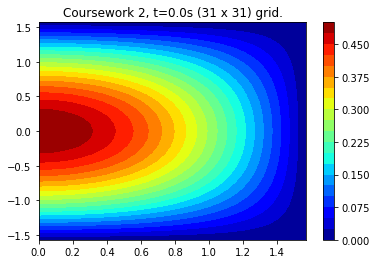

In [2]:
def coursework2(ni,nj):
    ''' set up an ni x nj grid to solver the problem specified in Coursework No 2.
    \begin{align}
        \frac{\partial u(x,y,t)}{\partial t} &= \kappa \left(\frac{\partial^2 u(x,y,t)}{\partial x^2}+\frac{\partial^2 u(x,y,t)}{\partial y^2}\right) \label{eq:2D_PDE}
    \end{align}
    on the interval $0\le x\le\frac\pi2, -\frac\pi2\le y\le \frac\pi2$ with the initial condition
    \begin{align}
        u(x,y,0) &= 0.5\cos(x)\cos(y) 
    \end{align}
    with $\kappa=2$.
    '''
    
    # create the mesh
    mesh = Grid(ni,nj)
    mesh.set_origin(0.0,-0.5*np.pi)
    mesh.set_extent(np.pi/2,np.pi)
    mesh.set_diffusivity(2.0)
    mesh.generate()
     
    # now set the inital conditions
    mesh.u = 0.5*np.cos(mesh.y)*np.cos(mesh.x)

    return mesh

# test it
grid = coursework2(31,31)
grid.plot('Coursework 2')
print(grid)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

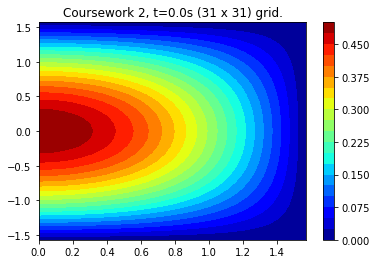

In [3]:
def set_boundary_conditions(mesh,time):
    '''set the boundaty conditions for coursework 2.  These are
    \begin{align}
        u(0,y,t) &= 0.5\cos(y)\exp(-\kappa t) \quad &\forall t\ge0, -\frac\pi2\le y\le \frac\pi2, \label{eq:2D_left_boundary} \\
        u\left(\frac\pi2,y,t\right) &= t\cos y \quad &\forall t\ge0, -\frac\pi2\le y\le \frac\pi2, \label{eq:2D_right_boundary} \\
        u\left(x,\pm\frac\pi2,t\right) &= 0, \quad &\forall t\ge0, 0\le x \le\frac\pi2,\label{eq:2D_top_bottom_boundary}
    \end{align}
    '''
    
    # x=0 boundary
    mesh.u[:,0] = 0.5*np.cos(mesh.y[:,0])*np.exp(-mesh.kappa*time)
    
    # x=pi/2 bounary
    mesh.u[:,-1] = time*np.cos(mesh.y[:,0])
    
    # y boundaries
    mesh.u[0,:] = 0.0
    mesh.u[-1,:] = 0.0

# test it
set_boundary_conditions(grid,0.0)
grid.plot('Coursework 2')


In [4]:
import scipy.sparse as sps
import scipy.sparse.linalg as LA

def Crank_Nicholson(mesh,t_stop,Courant_no=5.0):
    '''Advance the solution from the current time to t=t_stop
    using the Crank-Nicholson method with the specified time
    step delta_t'''
    
    # calculate delta_t based on the Courant Number nu
    delta_t = Courant_no*min(mesh.Delta_x()**2/(2*mesh.kappa), mesh.Delta_y()**2/(2*mesh.kappa));
    maxit = int((t_stop-mesh.time)/delta_t)
    out_it = maxit // 50
    
    print('Crank Nicholson with ∆t={:.4g} ({:d} times steps)'.format(delta_t,maxit))
    
    # Create the A matrix using the lil format and the b vector
    # as numpy vector.
    N = (grid.Nj-2)*(grid.Ni-2)
    A_mat = sps.lil_matrix((N, N), dtype=np.float64)
    x_vec = np.zeros(N, dtype=np.float64)
    b_vec = np.zeros(N, dtype=np.float64)

    # calculate the rx and ry and the a,b and c coeeficients
    rx = mesh.kappa*delta_t/mesh.Delta_x()**2
    ry = mesh.kappa*delta_t/mesh.Delta_y()**2

    # now build the A matricies
    for i in range(1,mesh.Ni-1):
        for j in range(1,mesh.Nj-1):
            k = (i-1) + (mesh.Ni-2)*(j-1)
                
            # set the leading diagonal coefficient
            A_mat[k,k] = 1 + rx + ry
               
            # i direction
            for m in range(i-1,i+2,2):
                if not(m<1 or m>mesh.Ni-2):
                    l = (m-1) + (mesh.Ni-2)*(j-1)
                    A_mat[k,l] = -rx/2

            # j direction
            for m in range(j-1,j+2,2):
                if not(m<1 or m>mesh.Nj-2):
                    l = (i-1) + (mesh.Ni-2)*(m-1)
                    A_mat[k,l] = -ry/2
    
    # assemble the preconditioner
    ilu = LA.spilu(A_mat.tocsc(), drop_tol=1e-6, fill_factor=100)
    M_mat = LA.LinearOperator(A_mat.shape, ilu.solve)

    # set an itteration counter
    it = 0
        
    # time loop
    status = 1
    while mesh.time < t_stop:
        #progress counter
        if it % out_it ==0:
            print('#',end='')
            
        # ensure we don't overshoot the stop time
        dt = min(delta_t, t_stop-mesh.time)
        
        # set the boundary conditions
        set_boundary_conditions(mesh,mesh.time)
        
        # extract the x_vector 
        x_vec = np.reshape(mesh.u[1:-1,1:-1],(N))

        # % Calculate the b vector using the values from the current time step
        for i in range(1,mesh.Ni-1):
            for j in range(1,mesh.Nj-1):
                k = (i-1) + (mesh.Ni-2)*(j-1)
                
                # b(k) calculate from the stencil for the current time step
                b_vec[k]=mesh.u[j,i] \
                    + rx*(mesh.u[j,i-1] - 2*mesh.u[j,i] + mesh.u[j,i+1])/2 \
                    + ry*(mesh.u[j-1,i] - 2*mesh.u[j,i] + mesh.u[j+1,i])/2
 
        # Now apply the boundary conditions for the next time level
        set_boundary_conditions(mesh,mesh.time+dt)

        # update the b vector to include boundary conditions
        for i in range(1,mesh.Ni-1):
            for j in range(1,mesh.Nj-1):
                k = (i-1) + (mesh.Ni-2)*(j-1)
                
                # i direction
                for m in range(i-1,i+2,2):
                    if m<1 or m>mesh.Ni-2:
                        b_vec[k] += rx * mesh.u[j,m]/2

                # j direction
                for m in range(j-1,j+2,2):
                    if m<1 or m>mesh.Nj-2:
                        b_vec[k] += ry * mesh.u[m,i]/2
                        
        # solve the matrix system
        x_vec, status = LA.bicgstab(A_mat,b_vec,x0=x_vec,M=M_mat)
            
        if status==0:
            # unpack x_vec into u
            mesh.u[1:-1,1:-1] = np.reshape(x_vec,(mesh.Ni-2,mesh.Nj-2))
        if status != 0:
            break
        
        #update everything
        mesh.time += dt
        it += 1
    
    print('.')
    if status == 0:
        return it
    else:
        return -status

Uniform 101x101 grid from (0.0, -1.5707963267948966) to (0.0, -1.5707963267948966, 1.5707963267948966, 3.141592653589793).
Boundaries conditions are - left: Dirichlet, right: Dirichlet, top: Dirichlet, bottom: Dirichlet.
time =0
Crank Nicholson with ∆t=0.0003084 (6484 times steps)
###################################################.
6485 iterations completed.


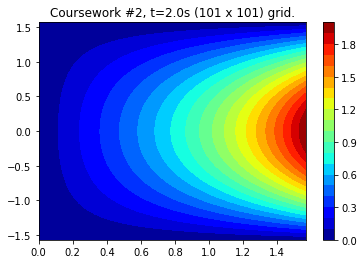

In [5]:
grid = coursework2(101,101)
print(grid)
it = Crank_Nicholson(grid, 2.0)
print(it,'iterations completed.')
grid.plot('Coursework #2')
plt.savefig('cw2-solution.pdf')

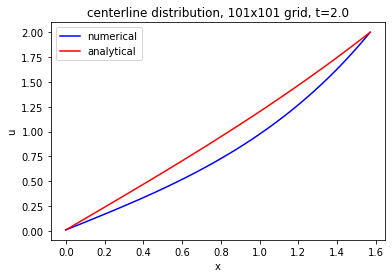

In [6]:
# plot the centerline solution
centre = grid.Nj // 2
plt.plot(grid.x[centre,:],grid.u[centre,:],'b-')

def analytical(mesh):
    t = mesh.time
    k = mesh.kappa
    u0 =  2*mesh.x[0,:]*t/np.pi + 0.5*np.cos(mesh.x[0,:])*np.exp(-k*t)
    for n in range(1,30):
        u0 = u0 + 0.5/(np.pi*k) * \
            (-1)**n/n**3 * (1-np.exp(-4*n**2*k*t))*np.sin(2*n*mesh.x[0,:])
    return u0

# and the analytical solution
ua = analytical(grid)
plt.plot(grid.x[centre,:],ua,'r')
plt.ylabel('u')
plt.xlabel('x')
plt.title(f'centerline distribution, {grid.Ni}x{grid.Nj} grid, t={grid.time}')
plt.legend(['numerical', 'analytical'])
plt.savefig('cw2-centerline.pdf')
plt.show()    



In [7]:
import scipy.integrate as integrate
from refinement_analysis import refinement_analysis

def integrate_u_dx(mesh,x0,x1,y):
    '''Calculate U=\int_x_0^\y_1u(x,y) dx  using the
    u value stored on the grid and simpsons rule'''
    
    # find the left and right grid points
    i0,j = mesh.find((x0,y))
    i1,j = mesh.find((x1,y))

    if i1==mesh.Ni:
        i1=-1
    
    # integrate
    return integrate.simps(mesh.u[j,i0:i1],mesh.x[j,i0:i1])

In [ ]:
import datetime # just seconds may not be enough

# we need some lists u and dx values
U_val = []
dx_val = []
run_time = []
n_pts =[]
for grid_index in range(5,-1,-1):
    ni = 10*2**grid_index + 1
    nj = 10*2**grid_index + 1
    n_pts.append(ni*nj)
    
    # set up the problem
    grid = coursework2(ni,nj)
    print(grid)
    
    # solve it with machine precision
    start = time.process_time()
    info = Crank_Nicholson(grid, 2.0)
    stop = time.process_time()
    print("The solver took {}, performing {} time steps" \
          .format(datetime.timedelta(seconds=int(stop-start)),info))

    # save dx and the integral
    dx_val.append(grid.Delta_x())
    U_val.append(integrate_u_dx(grid,0,pi/2,0.0))
    run_time.append(stop-start)

    print('Integrated value is ',U_val[-1],'\n')

Uniform 321x321 grid from (0.0, -1.5707963267948966) to (0.0, -1.5707963267948966, 1.5707963267948966, 3.141592653589793).
Boundaries conditions are - left: Dirichlet, right: Dirichlet, top: Dirichlet, bottom: Dirichlet.
time =0
Crank Nicholson with ∆t=3.012e-05 (66401 times steps)
################

In [ ]:
from refinement_analysis import refinement_analysis
# lets to the refinement analysis
analysis = refinement_analysis(dx_val,U_val)
analysis.report(r'$\int u dx$')
analysis.graph(True,r'$\int u dx$',filename='Figures/CW1-refinement.pdf')